In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import multiprocessing

from sklearn.impute import KNNImputer
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score

In [2]:
data = pd.read_csv('../datasets/dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       866 non-null    float64
 1   sex       866 non-null    float64
 2   cp        866 non-null    float64
 3   trestbps  809 non-null    float64
 4   chol      840 non-null    float64
 5   fbs       784 non-null    float64
 6   restecg   865 non-null    float64
 7   thalach   811 non-null    float64
 8   exang     811 non-null    float64
 9   oldpeak   806 non-null    float64
 10  slope     570 non-null    float64
 11  ca        297 non-null    float64
 12  thal      413 non-null    float64
 13  label     866 non-null    int64  
 14  split     866 non-null    object 
dtypes: float64(13), int64(1), object(1)
memory usage: 101.6+ KB


In [3]:
data = data.drop_duplicates()
X = data.drop(['label'], axis=1)
y = data['label'].astype(int)

In [4]:
X_test = pd.read_csv('../datasets/test_dataset.csv')
X_test['split'] = 'test'
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       50 non-null     float64
 1   sex       50 non-null     float64
 2   cp        50 non-null     float64
 3   trestbps  48 non-null     float64
 4   chol      46 non-null     float64
 5   fbs       43 non-null     float64
 6   restecg   49 non-null     float64
 7   thalach   50 non-null     float64
 8   exang     50 non-null     float64
 9   oldpeak   48 non-null     float64
 10  slope     38 non-null     float64
 11  ca        12 non-null     float64
 12  thal      20 non-null     float64
 13  split     50 non-null     object 
dtypes: float64(13), object(1)
memory usage: 5.6+ KB


In [5]:
X = pd.concat([X_test, X], axis=0)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915 entries, 0 to 865
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       915 non-null    float64
 1   sex       915 non-null    float64
 2   cp        915 non-null    float64
 3   trestbps  856 non-null    float64
 4   chol      885 non-null    float64
 5   fbs       826 non-null    float64
 6   restecg   913 non-null    float64
 7   thalach   860 non-null    float64
 8   exang     860 non-null    float64
 9   oldpeak   853 non-null    float64
 10  slope     608 non-null    float64
 11  ca        309 non-null    float64
 12  thal      433 non-null    float64
 13  split     915 non-null    object 
dtypes: float64(13), object(1)
memory usage: 107.2+ KB


In [6]:
X_test.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,split
0,56.0,1.0,2.0,124.0,224.0,1.0,0.0,161.0,0.0,2.0,2.0,NaN,NaN,test
1,61.0,1.0,4.0,125.0,0.0,0.0,0.0,105.0,1.0,0.0,3.0,NaN,7.0,test
2,52.0,1.0,4.0,135.0,0.0,NaN,0.0,128.0,1.0,2.0,2.0,NaN,7.0,test
3,64.0,1.0,4.0,120.0,0.0,1.0,1.0,106.0,0.0,2.0,2.0,NaN,NaN,test
4,49.0,1.0,1.0,130.0,0.0,0.0,1.0,145.0,0.0,3.0,2.0,NaN,NaN,test


## Data preprocessing

In [7]:
# Definimos variables categóricas y numéricas
categorical_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_vars = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
target = ['label']
    
def data_preprocessing(df, categorical_vars, numerical_vars):
    data = df.copy()
    # Eliminamos filas duplicadas
    data = data.drop_duplicates()

    # data[categorical_vars] = data[categorical_vars].astype(float).astype('Int64')
    # luego las pasamos a string, para que su valor 
    # numérico no influya en el análisis ni en las predicciones
    # data[categorical_vars + target] = data[categorical_vars + target].astype(str)
    # ca = 9 es un oulier, lo clippeamos a 3, que es el valor máximo según las especificaciones
    data['ca'] = data['ca'].replace(9.0, 3)

    # Reemplazamos 0s en chol y trestbps con NAs
    data[['trestbps', 'chol']] = data[['trestbps', 'chol']].replace(0, np.nan)

    # Clippeamos los outliers
    for var in ['trestbps', 'chol', 'thalach', 'oldpeak']:
        tmp_data = data[var][data[var] > 0].dropna()
        data.loc[data[var].isna(), var] = np.quantile(tmp_data, 0.5)
        q1, q3 = np.quantile(tmp_data, 0.25), np.quantile(tmp_data, 0.75)
        iqr = q3 - q1
        cut_off = iqr * 1.5
        lower, upper = q1 - cut_off, q3 + cut_off
        data.loc[data[var] > upper, var] = upper
        data.loc[data[var] < lower, var] = lower
        
    # Rellenamos los valores numéricos no informados
    data[numerical_vars] = data[numerical_vars].replace(pd.NA, np.nan)
    data[categorical_vars] = data[categorical_vars].replace(pd.NA, -1)
    imputer = KNNImputer(missing_values=np.nan, n_neighbors=11)
    data[numerical_vars + categorical_vars] = imputer.fit_transform(data[numerical_vars + categorical_vars])

    # Parseamos las variables categóricas como enteros, para eliminar los decimales
    data[categorical_vars] = data[categorical_vars].astype(int)
    return data

In [8]:
X = data_preprocessing(X, categorical_vars, numerical_vars)

In [9]:
X_test = data_preprocessing(X_test, categorical_vars, numerical_vars)

In [10]:
pd.DataFrame(X.eq(0).sum().to_dict(), index=[f"Zero values - total"])


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,split
Zero values - total,0,194,0,0,0,778,551,0,580,368,0,566,0,0


In [11]:
pd.DataFrame(X.isna().sum().to_dict(), index=[f"Missing values - total"])

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,split
Missing values - total,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
X[categorical_vars] = X[categorical_vars].astype(int)

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915 entries, 0 to 865
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       915 non-null    float64
 1   sex       915 non-null    int32  
 2   cp        915 non-null    int32  
 3   trestbps  915 non-null    float64
 4   chol      915 non-null    float64
 5   fbs       915 non-null    int32  
 6   restecg   915 non-null    int32  
 7   thalach   915 non-null    float64
 8   exang     915 non-null    int32  
 9   oldpeak   915 non-null    float64
 10  slope     915 non-null    int32  
 11  ca        915 non-null    int32  
 12  thal      915 non-null    int32  
 13  split     915 non-null    object 
dtypes: float64(5), int32(8), object(1)
memory usage: 78.6+ KB


In [14]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,split
0,56.0,1,2,124.0,224.0,1,0,161.0,0,2.0,2,0,5,test
1,61.0,1,4,125.0,239.5,0,0,105.0,1,0.0,3,0,7,test
2,52.0,1,4,135.0,239.5,0,0,128.0,1,2.0,2,1,7,test
3,64.0,1,4,120.0,239.5,1,1,106.0,0,2.0,2,1,5,test
4,49.0,1,1,130.0,239.5,0,1,145.0,0,3.0,2,0,5,test


In [15]:
# Escalamos los datos numéricos para que se ajusten a una distribución normal
X[numerical_vars] = scale(X[numerical_vars])

X[numerical_vars].describe()

,age,trestbps,chol,thalach,oldpeak
count,9.150000e+02,9.150000e+02,9.150000e+02,9.150000e+02,9.150000e+02
mean,3.570914e-16,7.132121e-16,-1.518973e-16,-3.681330e-16,-1.530045e-16
std,1.000547e+00,1.000547e+00,1.000547e+00,1.000547e+00,1.000547e+00
min,-2.716360e+00,-2.479877e+00,-2.957165e+00,-2.913631e+00,-1.409641e+00
25%,-6.942689e-01,-6.981976e-01,-5.837943e-01,-7.048058e-01,-9.105228e-01
50%,5.071222e-02,-1.043045e-01,-9.387826e-02,9.116718e-02,-1.119334e-01
75%,6.892674e-01,4.895886e-01,5.049080e-01,7.279455e-01,5.868323e-01
max,2.498507e+00,2.271268e+00,2.921827e+00,2.558683e+00,2.583306e+00


In [16]:
vals = { col: [sorted(list(X[col].dropna().unique()))] for col in categorical_vars }
pd.DataFrame(vals, index=['Unique values']).transpose()

,Unique values
sex,"[0, 1]"
cp,"[1, 2, 3, 4]"
fbs,"[0, 1]"
restecg,"[0, 1, 2]"
exang,"[0, 1]"
slope,"[1, 2, 3]"
ca,"[0, 1, 2, 3]"
thal,"[3, 4, 5, 6, 7]"


In [17]:
# ahora aplicamos OHE a las variables categóricas
ohe = OneHotEncoder(drop= 'first', sparse = False)
ohe_fit = ohe.fit(X[categorical_vars])
X_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_vars]))
X_ohe.columns = ohe_fit.get_feature_names_out()

X = pd.concat((X_ohe, X[numerical_vars + ['split']].reset_index()), axis=1)
X.set_index('index')
X.drop('index', axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915 entries, 0 to 914
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sex_1      915 non-null    float64
 1   cp_2       915 non-null    float64
 2   cp_3       915 non-null    float64
 3   cp_4       915 non-null    float64
 4   fbs_1      915 non-null    float64
 5   restecg_1  915 non-null    float64
 6   restecg_2  915 non-null    float64
 7   exang_1    915 non-null    float64
 8   slope_2    915 non-null    float64
 9   slope_3    915 non-null    float64
 10  ca_1       915 non-null    float64
 11  ca_2       915 non-null    float64
 12  ca_3       915 non-null    float64
 13  thal_4     915 non-null    float64
 14  thal_5     915 non-null    float64
 15  thal_6     915 non-null    float64
 16  thal_7     915 non-null    float64
 17  age        915 non-null    float64
 18  trestbps   915 non-null    float64
 19  chol       915 non-null    float64
 20  thalach   

In [18]:
X_train = X[X['split'] != 'test']

X_train = X_train.drop('split', axis=1)
X_test = X_test.drop('split', axis=1)

print(X_train.shape)
print(X_test.shape)

(865, 22)
(50, 13)


In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 50 to 914
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sex_1      865 non-null    float64
 1   cp_2       865 non-null    float64
 2   cp_3       865 non-null    float64
 3   cp_4       865 non-null    float64
 4   fbs_1      865 non-null    float64
 5   restecg_1  865 non-null    float64
 6   restecg_2  865 non-null    float64
 7   exang_1    865 non-null    float64
 8   slope_2    865 non-null    float64
 9   slope_3    865 non-null    float64
 10  ca_1       865 non-null    float64
 11  ca_2       865 non-null    float64
 12  ca_3       865 non-null    float64
 13  thal_4     865 non-null    float64
 14  thal_5     865 non-null    float64
 15  thal_6     865 non-null    float64
 16  thal_7     865 non-null    float64
 17  age        865 non-null    float64
 18  trestbps   865 non-null    float64
 19  chol       865 non-null    float64
 20  thalach  

In [20]:
counts = y.value_counts()

print(counts) 

{ n: round(100 * val / counts[0], 2) for n, val in counts.items() }

0    399
1    185
3    125
2    123
4     33
Name: label, dtype: int64


{0: 100.0, 1: 46.37, 3: 31.33, 2: 30.83, 4: 8.27}

In [21]:
# Como tenemos muy pocos datos de la clase 4, vamos a hacer oversampling para que esté más balanceado, 
# doblando el número de muestras de esta clase, de 33 a 66

sm = SMOTE(sampling_strategy={4: 120}, random_state = 1, k_neighbors = 7)
X, y = sm.fit_resample(X_train, y)

In [22]:
counts = y.value_counts()

{ n: round(100 * val / counts[0], 2) for n, val in counts.items() }

{0: 100.0, 1: 46.37, 3: 31.33, 2: 30.83, 4: 30.08}

## Random Forest Classifier

In [23]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier as XGBC # XGBoost


In [24]:
def kfold_test(model, n_splits, X, y):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cv_score =[]
    for train_idx, val_idx in kf.split(X, y):
        x_tr, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        #model
        model.fit(x_tr,y_tr)
        score_f1 = f1_score(y_val, model.predict(x_val), average='micro')
        cv_score.append(score_f1)

    return cv_score

def grid_search(model, params, X, y, n_splits = 5, n_jobs = multiprocessing.cpu_count() - 1, scoring = 'f1_micro'):
    grid = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring=scoring,
                        cv=n_splits, 
                        verbose=1,
                        n_jobs=n_jobs)
    grid.fit(X, y)
    print(f'Best params : {grid.best_params_}')
    print(f'Best score: {grid.best_score_}')
    return grid

In [25]:
# Xgboost params
nrounds_values = [1, 2]
eta_values = [0.3, 0.99]
gamma_values = [0, 1]
max_depth_values = [6, 20]
min_child_weight_values = [1, 20]
subsample_values = [0.1, 1]
colsample_bytree_values = [0.1, 1]
num_parallel_tree_values = [1, 10]
lambda_values = [0, 1]
alpha_values = [0, 1]

In [26]:
model_xgb = XGBC(random_state = 1, 
               class_weight = {0: 1, 1: 2, 2: 2, 3: 2, 4: 2})

In [27]:
model_xgb.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight={0: 1, 1: 2, 2: 2, 3: 2, 4: 2},
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)>

In [28]:
params = {
'nrounds': nrounds_values,
'eta': eta_values, 
'gamma': gamma_values,
'max_depth': max_depth_values,
'min_child_weight': min_child_weight_values,
'subsample': subsample_values,
'colsample_bytree': colsample_bytree_values,
'num_parallel_tree': num_parallel_tree_values,
'lambda': lambda_values,
'alpha': alpha_values
}


grid = grid_search(model_xgb, params, X, y, n_jobs = multiprocessing.cpu_count() - 1)

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
[22:06:42] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight", "nrounds" } are not used.

Best params : {'alpha': 1, 'colsample_bytree': 0.1, 'eta': 0.99, 'gamma': 1, 'lambda': 1, 'max_depth': 6, 'min_child_weight': 20, 'nrounds': 1, 'num_parallel_tree': 10, 'subsample': 1}
Best score: 0.5924882887847892


In [30]:
best_config = grid.best_params_

model_xgb = XGBC(nrounds = best_config['nrounds'], 
               eta = best_config['eta'],
               gamma = best_config['gamma'],
               max_depth = best_config['max_depth'],
               min_child_weight = best_config['min_child_weight'],
               subsample = best_config['subsample'],
               colsample_bytree = best_config['colsample_bytree'], # best_config['weight']
               class_weight = {0:1, 1: 2, 2: 2, 3: 2, 4: 2},  
               num_parallel_tree = best_config['num_parallel_tree'],
               reg_lambda = best_config['lambda'],
               alpha = best_config['alpha'],
               n_jobs = 7,
               random_state = 1)

model_xgb.fit(X, y)

pred_y = model_xgb.predict(X)

print(f"F1 score (train): {f1_score(y, pred_y, average='micro')}")

f1_scores = kfold_test(model_xgb, 10, X, y)

print(f"F1 score 10-fold: {np.mean(f1_scores)}")

[22:07:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight", "nrounds" } are not used.

F1 score (train): 0.6754201680672269
[22:07:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight", "nrounds" } are not used.

[22:07:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight", "nrounds" } are not used.

[22:07:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight", "nrounds" } are not used.

[22:07:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgb

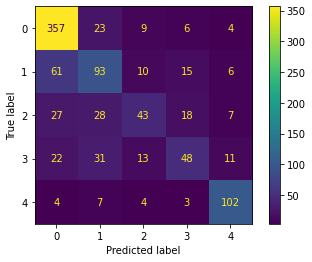

In [31]:
conf_matrix = confusion_matrix(y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model_xgb.classes_)
disp.plot()

### Random Forest sin usar class_weights

In [ ]:
model_rf2 = RFC(random_state = 1)

In [ ]:
params = {
'criterion': ['entropy', 'gini'],
'min_samples_leaf': [2, 3, 4], 
'min_samples_split': [2, 3, 4, 5, 6],
'max_depth': [5, 7, 9, 11, 12, 13, 14],
'max_features': [5, 7, 10, 15, 21],
'n_estimators': [25, 50, 75]
}


grid = grid_search(model_rf2, params, X, y, n_jobs =6)

In [ ]:
params = {
'criterion': ['entropy'],
'min_samples_leaf': [2, 3], 
'min_samples_split': [4, 5, 6],
'max_depth': [8, 9, 10],
'max_features': [5, 6, 7],
'n_estimators': [75, 100]
}
grid = grid_search(model_rf2, params, X, y, n_jobs =6)

In [ ]:
best_config = grid.best_params_

model_rf2 = RFC(criterion = best_config['criterion'], 
               min_samples_leaf = best_config['min_samples_leaf'],
               min_samples_split = best_config['min_samples_split'],
               max_depth = best_config['max_depth'],
               max_features = best_config['max_features'],
               n_estimators = 100, # best_config['n_estimators'], 
               # class_weight = {0:1, 1: 2, 2: 2, 3: 2, 4: 2}, # best_config['weight']
               n_jobs = 7,
               random_state = 1)

model_rf2.fit(X, y)

pred_y = model_rf2.predict(X) 

print(f"F1 score (train): {f1_score(y, pred_y, average='micro')}")

f1_scores = kfold_test(model_rf, 10, X, y)

print(f"F1 score 10-fold: {np.mean(f1_scores)}")

In [39]:
# Escalamos los datos numéricos para que se ajusten a una distribución normal
X_test[numerical_vars] = scale(X_test[numerical_vars])

X_test[numerical_vars].describe()

# ahora aplicamos OHE a las variables categóricas
ohe_fit_test = ohe.fit(X_test[categorical_vars])
X_test_ohe = pd.DataFrame(ohe.fit_transform(X_test[categorical_vars]))
X_test_ohe.columns = ohe_fit.get_feature_names_out()

X_test = pd.concat((X_test_ohe, X_test[numerical_vars].reset_index()), axis=1)
X_test.set_index('index')
X_test.drop('index', axis=1, inplace=True)
X_test.info()

KeyError: "None of [Index(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'], dtype='object')] are in the [columns]"

In [ ]:
X_test = pd.concat

### Predicciones para el test dataset

In [38]:
pred_y_test = model_xgb.predict(X_test)
pred_df = pd.DataFrame({'ID': X_test.index.values, 'label': pred_y_test.astype(int)})
pred_df.to_csv('../submission_xgb.csv', index=False)

!head '../submission_xgb.csv'

ValueError: Feature shape mismatch, expected: 22, got 21

In [ ]:
pred_df

In [ ]:
y_rf = pd.read_csv('../submission_rf.csv')

conf_matrix = confusion_matrix(y_rf['label'], pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model_rf.classes_)
disp.plot()